# plot CL vs CD

In [1]:
task = 'cross_validation' 
force = 'CL'     
filt = 'bessel' # only for cp; no cl or cd filter

if task == 'cross_validation':
    folds = 7
    print('Post process for ', force)
elif task == 'predict':
    folds = 1
else:
    print('Error. Please define your task.') 
print('Define the task complete.')

Post process for  CL
Define the task complete.


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import bessel
from scipy.signal import filtfilt

#Load the variable
num_neuron = [16, 24, 32, 40, 48, 56, 64, 72]
num_layer  = [1,  2,  3  ,4,  5,  6,  7,  8]
epoch_total = 200


In [4]:
# read data
# folder path
data_path = 'D:/myProject/Exam/Thesis/dashuai/deltaWing/organized_data_from_Frieder/data_force_on_earth_Coordinate_System/' + '2023-01-11-filter-no/gust_dataframe.csv'

# read the excel data
gust_origin = pd.read_csv(data_path)

In [5]:
# check data
gust_origin.head()

,case_number,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
0,case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897,0.533331,0.125085
1,case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896,0.520047,0.117766
2,case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073,0.527826,0.136049
3,case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709,0.546522,0.142592
4,case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797,0.518274,0.123129


In [6]:
# set the first column as index, i.e. set case_nn as index, for convenience
gust_origin.set_index('case_number', inplace=True)
print(gust_origin.shape)
# check the first 5 columns
gust_origin.head()

(80000, 18)


,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
case_number,,,,,,,,,,,,,,,,,,
case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897,0.533331,0.125085
case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896,0.520047,0.117766
case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073,0.527826,0.136049
case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709,0.546522,0.142592
case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797,0.518274,0.123129


In [7]:
# bessel filter for every column; only filt CP
if filt == 'bessel':
    
    gust_index   = gust_origin.index
    gust_column  = gust_origin.columns
    gust_no_filter = np.zeros((gust_index.nunique(),len(gust_origin.loc[['case_01']]),len(gust_origin.columns))) # (32,2500,18)
    gust_filter    = np.zeros((gust_index.nunique(),len(gust_origin.loc[['case_01']]),len(gust_origin.columns)))
    case_all_no = (np.linspace(0,31,32)).astype(int)
    b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
    
    for i in case_all_no:      # i is the case number
        case_numer = 'case_' + str(i+1).zfill(2)
        gust_no_filter[i] = gust_origin.loc[[case_numer]].to_numpy()
        for j in range(len(gust_origin.columns)-2):       # j is the CP and CL CD number
            gust_filter[i][:,j] = filtfilt(b, a, gust_no_filter[i][:,j]) # bessel filter for cp
        gust_filter[i][:,len(gust_origin.columns)-2] = gust_no_filter[i][:,len(gust_origin.columns)-2]  # no filter for CL
        gust_filter[i][:,len(gust_origin.columns)-1] = gust_no_filter[i][:,len(gust_origin.columns)-1]  # no filter for CD
    gust = pd.DataFrame(data=np.concatenate(gust_filter,axis=0), index=gust_index, columns=gust_column)
    
elif filt == 'no filter':
    gust = gust_origin
    
else:
    print('Error. Please define your filter.')

In [8]:
# check gust
gust.head()

,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
case_number,,,,,,,,,,,,,,,,,,
case_01,-0.988974,-0.586905,-0.748616,-0.957996,-0.410183,-0.453233,-0.557431,-0.739092,-0.992419,-0.240811,-0.273363,-0.319737,-0.390677,-0.578497,-1.209126,0.910049,0.533331,0.125085
case_01,-0.988473,-0.586439,-0.748343,-0.957563,-0.409834,-0.452906,-0.557062,-0.738562,-0.992191,-0.240630,-0.273239,-0.319615,-0.390579,-0.578188,-1.208478,0.911292,0.520047,0.117766
case_01,-0.987969,-0.585972,-0.748068,-0.957128,-0.409484,-0.452579,-0.556692,-0.738033,-0.991963,-0.240448,-0.273115,-0.319492,-0.390481,-0.577878,-1.207829,0.912535,0.527826,0.136049
case_01,-0.987465,-0.585503,-0.747792,-0.956691,-0.409135,-0.452251,-0.556321,-0.737505,-0.991734,-0.240265,-0.272989,-0.319369,-0.390382,-0.577566,-1.207179,0.913778,0.546522,0.142592
case_01,-0.986959,-0.585033,-0.747516,-0.956253,-0.408785,-0.451923,-0.555948,-0.736977,-0.991504,-0.240080,-0.272864,-0.319246,-0.390283,-0.577253,-1.206529,0.915022,0.518274,0.123129


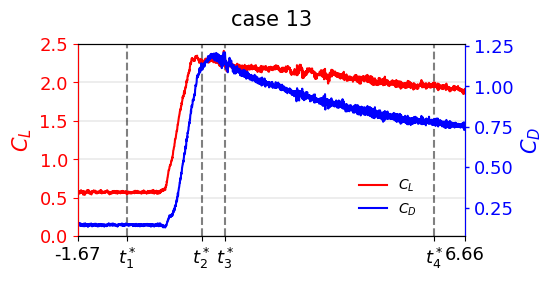

In [41]:
# plot CL and CD together
T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = (np.arange(0,10000)-500) / f / T 

# four test cases: 13 20 25 28
case_to_show_force = 13
gust_to_show_force = gust.loc['case_' + str(case_to_show_force).zfill(2)]
fig,ax1 = plt.subplots(figsize=(5,2.5))
ax1.plot(t_star[0:2500], gust_to_show_force[['CL']].to_numpy(),color='red',label='$C_L$')
ax1.tick_params(axis='x',labelsize=13)
ax1.tick_params(axis='y', colors='red',labelsize=13)
# ax1.set_xticklabels(np.arange(-1.5,6.6,0.5), rotation=45)
# ax1.set_xlim(0,8)
ax1.margins(x=0)
ax1.grid(which='both', axis='both', color='k', linestyle='-', linewidth=0.1)
# ax1.set_xlabel('$t^*$',fontsize=15)
ax1.set_ylabel('$C_L$',fontsize=15, color='red')

ax2 = ax1.twinx()
ax2.plot(t_star[0:2500],gust_to_show_force[['CD']].to_numpy(),color='blue',label='$C_D$')
ax2.spines['right'].set_color('blue')
ax2.spines['left'].set_color('red')
ax2.set_ylabel('$C_D$',fontsize=15, color='blue')
ax2.tick_params(axis='y', direction='out', length=3, width=1, colors='blue', labelsize=13,
               grid_color='gray', grid_alpha=0.5)
ax2.margins(x=0)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center', bbox_to_anchor=(0.8, 0.2), ncol=1, frameon=False)
ax1.set_title('case %d' % (case_to_show_force),fontsize=15, y=1.05)
# ax1.tick_params(axis='x', direction='out', length=3, width=1, colors='black',
#                grid_color='gray', grid_alpha=0.5)
# ax1.tick_params(axis='y', direction='out', length=3, width=1, colors='red',
#                grid_color='gray', grid_alpha=0.5)

ax1.grid(axis='x')

# this is for paper
# t_star_show = np.array([-0.6,1,1.5,6]). 
for i in range(4):
    ax1.axvline(x=t_star_show[i], color='gray', linestyle='--', zorder=1)

ax1.set_xticks(np.round([np.min(t_star[0:2500]), t_star_show[0], t_star_show[1], 
                t_star_show[2], t_star_show[3], np.max(t_star[0:2500])],2))

ax1.set_xticklabels([round(np.min(t_star[0:2500]),2), '$t_1^*$', '$t_2^*$', 
                    '$t_3^*$', '$t_4^*$', round(np.max(t_star[0:2500]),2)], fontsize=13)

# set different y lim for the four cases
if case_to_show_force == 13:
    # for case 13
    ax1.set_yticks([0.5,1,0,1.5,2,2.5])
    ax2.set_yticks([0.25,0.5,0.75,1,1.25])
    
elif case_to_show_force == 20:
    # for case 20
    ax1.set_yticks([0,0.5,1,0,1.5])
    ax2.set_yticks([-0.1,0,0.1,0.2,0.3,0.4])
    
elif case_to_show_force == 25:
    # for case 25
    ax1.set_yticks([0,0.25,0.5,0.75,1,1.25])
    ax2.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
    
else:
    # for case 28
    ax1.set_yticks([-0.5,-0.25,0,0.25,0.5,0.75])
    ax2.set_yticks([-0.1,0,0.1,0.2,0.3])

# fig.savefig('CL_CD_case%d.svg' % (case_to_show_force), bbox_inches='tight')

**create gif, Synchronizing with the pressure map created by matlab**  
300:5:1300 from matlab creating pressure map

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio

# create an empty list to store the figures
frames = []

x = np.arange((300-500)/1000/0.3, (1300-500)/1000/0.3, 5/1000/0.3)

# four test cases: 13 20 25 28
case_to_show_force = 20
gust_to_show_force = gust.loc['case_' + str(case_to_show_force).zfill(2)]

for ii in range(200):

    # plot CL and CD together
    T = 0.3 # period is 0.3s
    f = 1000 # frequency is 1000Hz
    t_star = (np.arange(0,10000)-500) / f / T 
    
    fig,ax1 = plt.subplots(figsize=(5,2.5))

    ax1.plot(t_star[0:2500], gust_to_show_force[['CL']].to_numpy(),color='red',label='$C_L$')
    ax1.tick_params(axis='x',labelsize=13)
    ax1.tick_params(axis='y', colors='red',labelsize=13)
    # ax1.set_xticklabels(np.arange(-1.5,6.6,0.5), rotation=45)
    # ax1.set_xlim(0,8)
    ax1.margins(x=0)
    ax1.grid(which='both', axis='both', color='k', linestyle='-', linewidth=0.1)
    # ax1.set_xlabel('$t^*$',fontsize=15)
    ax1.set_ylabel('$C_L$',fontsize=15, color='red')

    ax2 = ax1.twinx()
    ax2.plot(t_star[0:2500],gust_to_show_force[['CD']].to_numpy(),color='blue',label='$C_D$')
    ax2.spines['right'].set_color('blue')
    ax2.spines['left'].set_color('red')
    ax2.set_ylabel('$C_D$',fontsize=15, color='blue')
    ax2.tick_params(axis='y', direction='out', length=3, width=1, colors='blue', labelsize=13,
                   grid_color='gray', grid_alpha=0.5)
    ax2.margins(x=0)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='center', bbox_to_anchor=(0.8, 0.2), ncol=1, frameon=False)
    ax1.set_title('case %d' % (case_to_show_force),fontsize=15, y=1.05)
    # ax1.tick_params(axis='x', direction='out', length=3, width=1, colors='black',
    #                grid_color='gray', grid_alpha=0.5)
    # ax1.tick_params(axis='y', direction='out', length=3, width=1, colors='red',
    #                grid_color='gray', grid_alpha=0.5)

    ax1.grid(axis='x')

    # this is for paper
    # t_star_show = np.array([-0.6,1,1.5,6]). 
    # for i in range(4):
    #     ax1.axvline(x=t_star_show[i], color='gray', linestyle='--', zorder=1)

    # this is for ppt  300:5:1300 from matlab creating pressure map
    # sampling frequency = 1000Hz; period = 0.3s,
    ax1.axvline(x[ii], color='gray', linestyle='--', zorder=1)

    ax1.set_xticks([-0.67, 0, 1, 2.67, 5, 6.66])

    ax1.set_xticklabels(['-0.67','0','1','2.67','5','6.66'], fontsize=10)

    # set different y lim for the four cases
    if case_to_show_force == 13:
        # for case 13
        ax1.set_yticks([0.5,1,0,1.5,2,2.5])
        ax2.set_yticks([0.25,0.5,0.75,1,1.25])

    elif case_to_show_force == 20:
        # for case 20
        ax1.set_yticks([0,0.5,1,0,1.5])
        ax2.set_yticks([-0.1,0,0.1,0.2,0.3,0.4])

    elif case_to_show_force == 25:
        # for case 25
        ax1.set_yticks([0,0.25,0.5,0.75,1,1.25])
        ax2.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])

    else:
        # for case 28
        ax1.set_yticks([-0.5,-0.25,0,0.25,0.5,0.75])
        ax2.set_yticks([-0.1,0,0.1,0.2,0.3])
    
    # Save the plot as an image
    plt.tight_layout()
    fig.savefig('./figure/case_'+str(case_to_show_force)+'/frame_{:03d}.png'.format(ii), dpi = 350)
    plt.close()
    
    # Read the saved image and append it to the list of frames
    frame = imageio.imread('./figure/case_'+str(case_to_show_force)+'/frame_{:03d}.png'.format(ii))
    frames.append(frame)
    
print('Done!')

Done!


In [84]:
# Save the frames as an animated GIF
imageio.mimsave('./figure/case'+str(+case_to_show_force)+'.gif', frames, 'GIF', duration=0.0333)
print('Done!')

Done!
